Because of large file size, memory usage is high with multiple dataframes. Splitting Data Story into parts avoids memory errors from occuring.

In [60]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import scipy.stats as stats
import numpy as np

In [2]:
crash = pd.read_csv('crashdata.csv')
crash_sev_loc = pd.read_pickle('crash_sev_loc.pkl')

C:\Users\Ari\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (79,183) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
crash_sev_loc['danger'] = crash_sev_loc.severity/(crash_sev_loc.traffic * 4728)

In [4]:
crash_conditions = crash.loc[:, ('WEATHER', 'ILLUMINATION', 'INTERSECT_TYPE', 'LOCATION_TYPE', 'RELATION_TO_ROAD', 'ROAD_CONDITION', 'SPEED_LIMIT', 'TCD_FUNC_CD', 'TCD_TYPE', 'DEC_LAT', 'DEC_LONG')]
crash_conditions.head()

,WEATHER,ILLUMINATION,INTERSECT_TYPE,LOCATION_TYPE,RELATION_TO_ROAD,ROAD_CONDITION,SPEED_LIMIT,TCD_FUNC_CD,TCD_TYPE,DEC_LAT,DEC_LONG
0,1.0,2.0,0.0,0.0,2.0,0.0,35.0,0.0,0.0,40.3234,-79.9404
1,1.0,1.0,0.0,0.0,5.0,6.0,35.0,0.0,0.0,40.3182,-79.9076
2,1.0,2.0,3.0,0.0,5.0,0.0,35.0,3.0,3.0,40.4886,-80.3371
3,1.0,1.0,1.0,0.0,1.0,1.0,25.0,3.0,2.0,NaN,NaN
4,1.0,3.0,0.0,0.0,1.0,0.0,20.0,0.0,0.0,NaN,NaN


In [5]:
crash_conditions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157821 entries, 0 to 157820
Data columns (total 11 columns):
WEATHER             157802 non-null float64
ILLUMINATION        157821 non-null float64
INTERSECT_TYPE      157821 non-null float64
LOCATION_TYPE       157821 non-null float64
RELATION_TO_ROAD    157821 non-null float64
ROAD_CONDITION      157821 non-null float64
SPEED_LIMIT         152226 non-null float64
TCD_FUNC_CD         157820 non-null float64
TCD_TYPE            157821 non-null float64
DEC_LAT             147836 non-null float64
DEC_LONG            147834 non-null float64
dtypes: float64(11)
memory usage: 13.2 MB


In [6]:
crash_sev_loc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141776 entries, 0 to 1170299
Data columns (total 19 columns):
FATAL                 141776 non-null float64
FATAL_COUNT           141776 non-null float64
FATAL_OR_MAJ_INJ      141776 non-null float64
INJURY                141776 non-null float64
INJURY_COUNT          141776 non-null float64
MAJ_INJ_COUNT         141776 non-null float64
MAJOR_INJURY          141776 non-null float64
MAX_SEVERITY_LEVEL    141776 non-null float64
VEHICLE_COUNT         141776 non-null float64
DEC_LAT               141776 non-null float64
DEC_LONG              141776 non-null float64
STREET_NAME           141776 non-null object
datetime              141776 non-null datetime64[ns]
ecef                  141776 non-null object
sensor_distance       141776 non-null float64
traffic               141776 non-null float64
max_traffic           141776 non-null float64
severity              141776 non-null float64
danger                141776 non-null float64
dtypes: d

In [7]:
# Merge and drop duplicates
crash_sev_loc_cond = crash_conditions.merge(crash_sev_loc, on=['DEC_LAT','DEC_LONG'])
crash_sev_loc_cond.drop_duplicates(subset = ['datetime','DEC_LAT','DEC_LONG'], inplace = True)

In [8]:
crash_sev_loc_cond.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141776 entries, 0 to 1168739
Data columns (total 28 columns):
WEATHER               141762 non-null float64
ILLUMINATION          141776 non-null float64
INTERSECT_TYPE        141776 non-null float64
LOCATION_TYPE         141776 non-null float64
RELATION_TO_ROAD      141776 non-null float64
ROAD_CONDITION        141776 non-null float64
SPEED_LIMIT           135286 non-null float64
TCD_FUNC_CD           141776 non-null float64
TCD_TYPE              141776 non-null float64
DEC_LAT               141776 non-null float64
DEC_LONG              141776 non-null float64
FATAL                 141776 non-null float64
FATAL_COUNT           141776 non-null float64
FATAL_OR_MAJ_INJ      141776 non-null float64
INJURY                141776 non-null float64
INJURY_COUNT          141776 non-null float64
MAJ_INJ_COUNT         141776 non-null float64
MAJOR_INJURY          141776 non-null float64
MAX_SEVERITY_LEVEL    141776 non-null float64
VEHICLE_COUNT 

In [9]:
weather_di = {1:'No adverse conditions',
              2: 'Rain',
              3: 'Sleet (hail)',
              4: 'Snow',
              5: 'Fog',
              6: 'Rain and fog',
              7: 'Sleet and fog',
              8: 'Other',
              9: np.NaN}
illumination_di = {1: 'Daylight',
                   2: 'Dark - no street lights',
                   3: 'Dark - street lights',
                   4: 'Dusk',
                   5: 'Dawn',
                   6: 'Dark - unknown roadway lighting',
                   8: 'Other',
                   9: np.NaN}
intersect_di = {0: 'Mid-block',
                1: 'Four way intersection',
                2: 'T intersection',
                3: 'Y intersection',
                4: 'Traffic circle/Round about',
                5: 'Multi-leg intersection',
                6: 'On ramp',
                7: 'Off ramp',
                8: 'Crossover',
                9: 'Railroad crossing',
                10: 'Other',
                99: np.NaN}
location_di = {0: 'Not applicable',
               1: 'Underpass',
               2: 'Ramp',
               3: 'Bridge',
               4: 'Tunnel',
               5: 'Toll Booth',
               6: 'Cross over related',
               7: 'Driveway or Parking Lot',
               8: 'Ramp and bridge',
               9: np.NaN}
relation_di = {1: 'On roadway',
               2: 'Shoulder',
               3: 'Median',
               4: 'Roadside',
               5: 'Outside trafficway',
               6: 'In parking lane',
               7: 'Gore',
               9: np.NaN}
# Gore is intersection of ramp and highway
road_cond = {0: 'Dry',
             1: 'Wet',
             2: 'Sand/mud/dirt/oil/gravel',
             3: 'Snow covered',
             4: 'Slush',
             5: 'Ice', 
             6: 'Ice Patches',
             7: 'Water - standing/moving',
             8: 'Other',
             9: np.NaN}
tcdtype_di = {0: np.NaN,
              1: 'Flashing traffic signal',
              2: 'Traffic signal',
              3: 'Stop sign',
              4: 'Yield sign',
              5: 'Active RR crossing controls',
              6: 'Passive RR crossing controls',
              7: 'Police officer or flagman',
              8: 'Other type TCD'}

In [10]:
crash_sev_loc_cond['WEATHER_DES'] = crash_sev_loc_cond.WEATHER.map(weather_di)
crash_sev_loc_cond['ILLUMINATION_DES'] = crash_sev_loc_cond.ILLUMINATION.map(illumination_di)
crash_sev_loc_cond['INTERSECT_DES'] = crash_sev_loc_cond.INTERSECT_TYPE.map(intersect_di)
crash_sev_loc_cond['LOCATION_DES'] = crash_sev_loc_cond.LOCATION_TYPE.map(location_di)
crash_sev_loc_cond['ROAD_RELATION_DES'] = crash_sev_loc_cond.RELATION_TO_ROAD.map(relation_di)
crash_sev_loc_cond['ROAD_CONDITION_DES'] = crash_sev_loc_cond.ROAD_CONDITION.map(road_cond)
crash_sev_loc_cond['TCD_DES'] = crash_sev_loc_cond.TCD_TYPE.map(tcdtype_di)
crash_sev_loc_cond.head()

,WEATHER,ILLUMINATION,INTERSECT_TYPE,LOCATION_TYPE,RELATION_TO_ROAD,ROAD_CONDITION,SPEED_LIMIT,TCD_FUNC_CD,TCD_TYPE,DEC_LAT,...,max_traffic,severity,danger,WEATHER_DES,ILLUMINATION_DES,INTERSECT_DES,LOCATION_DES,ROAD_RELATION_DES,ROAD_CONDITION_DES,TCD_DES
0,1.0,2.0,0.0,0.0,2.0,0.0,35.0,0.0,0.0,40.3234,...,816.0,1.0,0.000008,No adverse conditions,Dark - no street lights,Mid-block,Not applicable,Shoulder,Dry,NaN
1,1.0,1.0,0.0,0.0,5.0,6.0,35.0,0.0,0.0,40.3182,...,960.0,2.0,0.000009,No adverse conditions,Daylight,Mid-block,Not applicable,Outside trafficway,Ice Patches,NaN
2,1.0,2.0,3.0,0.0,5.0,0.0,35.0,3.0,3.0,40.4886,...,21.0,2.0,0.000022,No adverse conditions,Dark - no street lights,Y intersection,Not applicable,Outside trafficway,Dry,Stop sign
3,1.0,2.0,3.0,0.0,5.0,0.0,35.0,3.0,3.0,40.4886,...,1153.0,2.0,0.000033,No adverse conditions,Dark - no street lights,Y intersection,Not applicable,Outside trafficway,Dry,Stop sign
4,1.0,2.0,3.0,0.0,5.0,0.0,35.0,3.0,3.0,40.4886,...,21.0,2.0,0.000024,No adverse conditions,Dark - no street lights,Y intersection,Not applicable,Outside trafficway,Dry,Stop sign


,severity,traffic,frequency
SPEED_LIMIT,,,
0.0,536.0,1.245512e+05,326
10.0,131.0,3.438733e+04,83
15.0,2810.0,6.012572e+05,1673
20.0,915.0,2.177248e+05,586
25.0,79527.0,1.760770e+07,48456
30.0,7628.0,1.468072e+06,4350
35.0,65702.0,1.485083e+07,37308
40.0,27182.0,5.759414e+06,14313
45.0,13711.0,2.856222e+06,7378


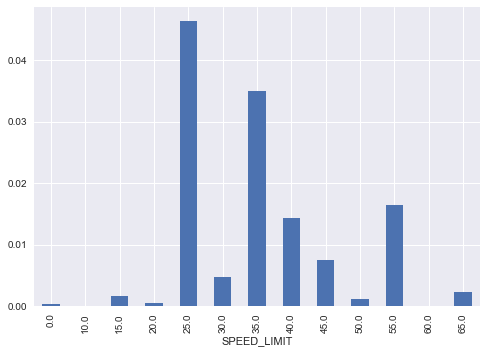

In [11]:
speed = crash_sev_loc_cond.groupby('SPEED_LIMIT').sum()
speed_frequency = crash_sev_loc_cond.groupby('SPEED_LIMIT').size()
speed.loc[:,['severity', 'traffic']]
s = (speed_frequency*speed.severity)/(speed.traffic * 4728)
r = (speed_frequency)/(speed.traffic * 4728)
s.plot(kind = 'bar')
speed['frequency'] = speed_frequency
speed.loc[:,['severity', 'traffic','frequency']]

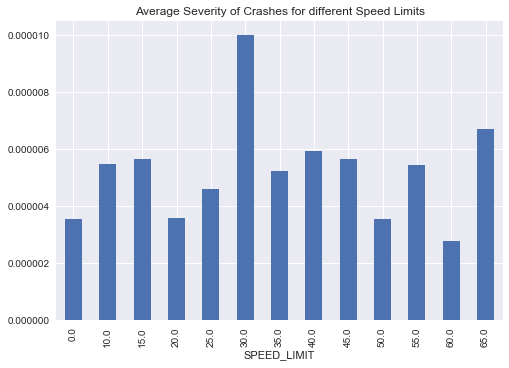

In [12]:
crash_sev_loc_cond.groupby('SPEED_LIMIT').mean().danger.plot(kind = 'bar')
plt.title('Average Severity of Crashes for different Speed Limits')

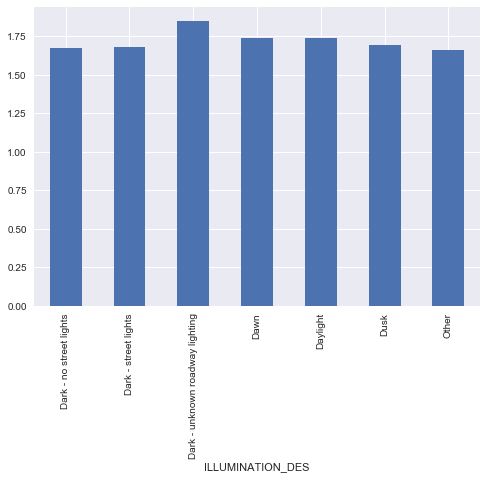

In [13]:
crash_sev_loc_cond.groupby('ILLUMINATION_DES').mean().severity.plot(kind = 'bar')

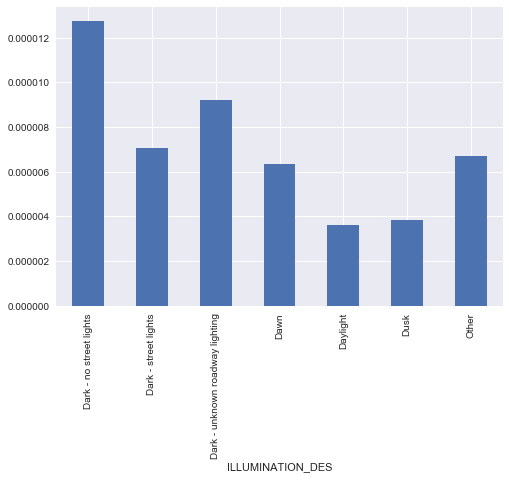

In [14]:
crash_sev_loc_cond.groupby('ILLUMINATION_DES').mean().danger.plot(kind = 'bar')

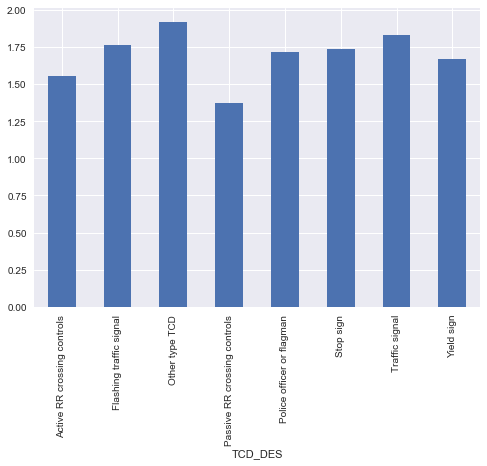

In [15]:
crash_sev_loc_cond.groupby('TCD_DES').mean().severity.plot(kind = 'bar')

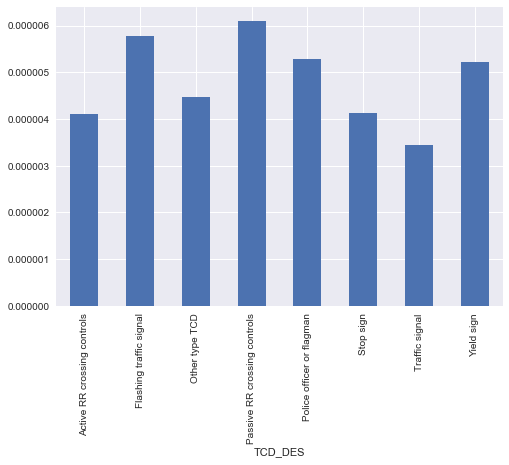

In [16]:
crash_sev_loc_cond.groupby('TCD_DES').mean().danger.plot(kind = 'bar')

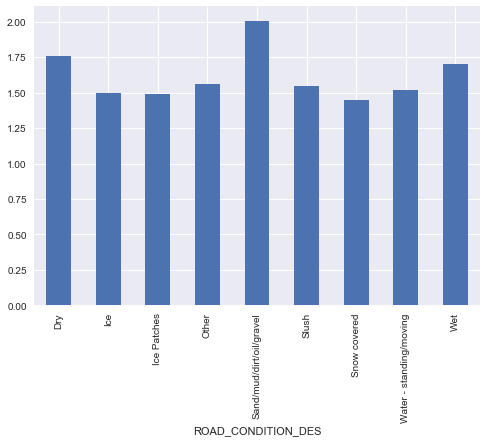

In [17]:
crash_sev_loc_cond.groupby('ROAD_CONDITION_DES').mean().severity.plot(kind = 'bar')

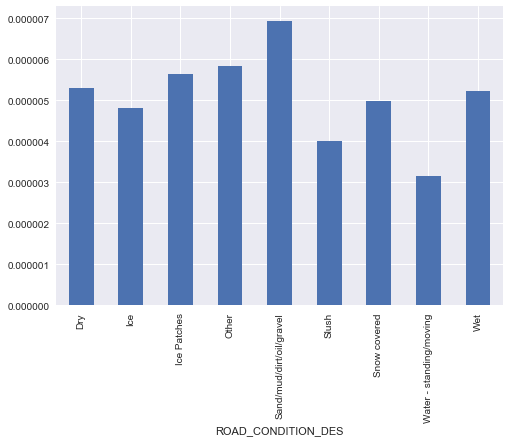

In [18]:
crash_sev_loc_cond.groupby('ROAD_CONDITION_DES').mean().danger.plot(kind = 'bar')

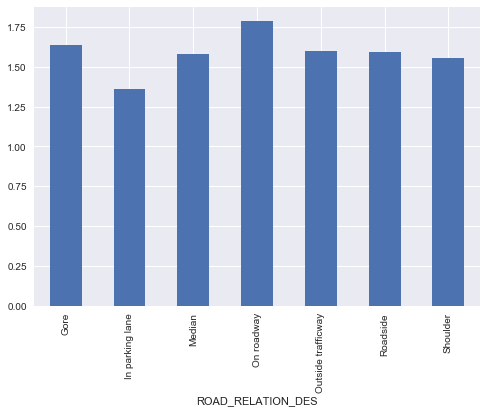

In [19]:
crash_sev_loc_cond.groupby('ROAD_RELATION_DES').mean().severity.plot(kind = 'bar')

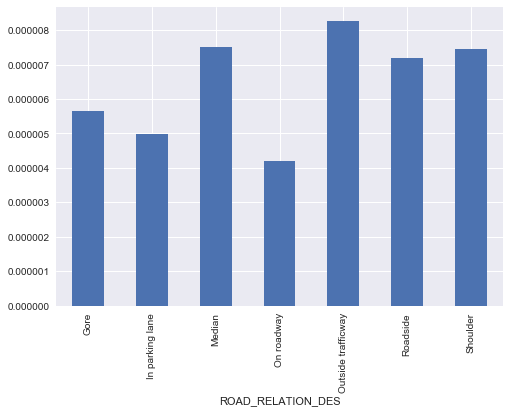

In [20]:
crash_sev_loc_cond.groupby('ROAD_RELATION_DES').mean().danger.plot(kind = 'bar')

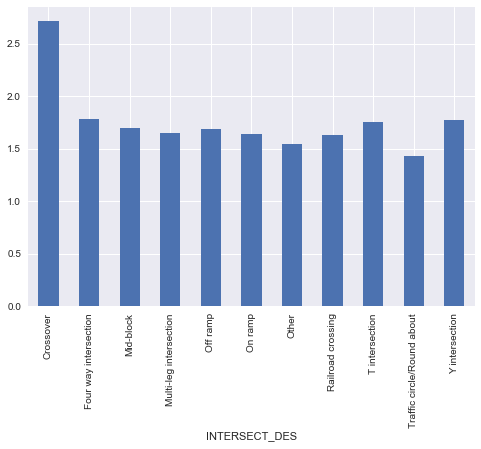

In [21]:
crash_sev_loc_cond.groupby('INTERSECT_DES').mean().severity.plot(kind = 'bar')

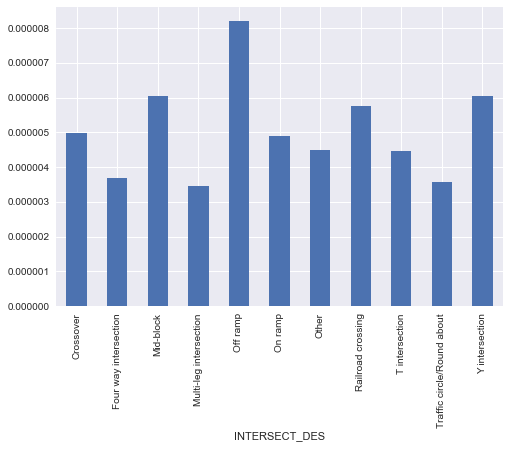

In [22]:
crash_sev_loc_cond.groupby('INTERSECT_DES').mean().danger.plot(kind = 'bar')

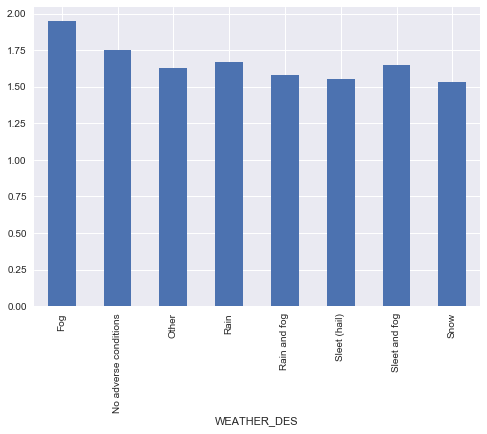

In [23]:
crash_sev_loc_cond.groupby('WEATHER_DES').mean().severity.plot(kind = 'bar')

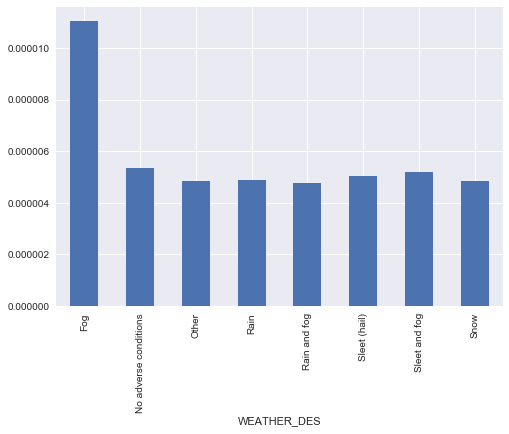

In [24]:
crash_sev_loc_cond.groupby('WEATHER_DES').mean().danger.plot(kind = 'bar')

In [25]:
danger_net = crash_sev_loc_cond.groupby('STREET_NAME').mean().danger

In [26]:
danger_net[danger_net.index.str.startswith('GILKESON')]
danger_net[danger_net.index.str.startswith('CEDAR BL')]
danger_net[danger_net.index.str.startswith('COCHRAN RD')]
danger_net[danger_net.index.str.startswith('BEVERLY RD')]
danger_net[danger_net.index.str.startswith('BANKSVILLE')]

STREET_NAME
BANKSVILLE AV                6.523613e-06
BANKSVILLE INT/RAMP E RD     7.969310e-07
BANKSVILLE INT/RMP 250 RD    3.510784e-07
BANKSVILLE INT/RMP 260 RD    5.193340e-06
BANKSVILLE RAMP RD           2.893378e-07
BANKSVILLE RD                5.650603e-06
Name: danger, dtype: float64

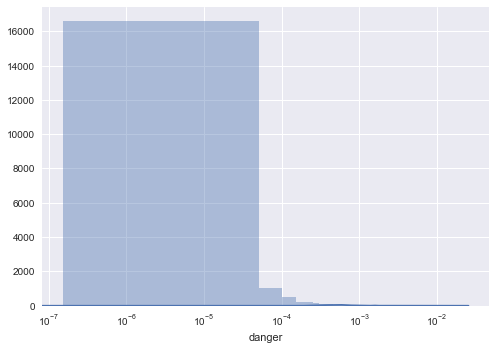

In [27]:
sns.distplot(crash_sev_loc_cond.groupby('STREET_NAME').sum().danger, bins = 500)
plt.xscale('log')


In [ ]:
sns.distplot(crash_sev_loc_cond.groupby('STREET_NAME').sum().danger, bins = 500)

In [30]:
import powerlaw as pl

In [34]:
data = crash_sev_loc_cond.groupby('STREET_NAME').sum().danger

In [38]:
type(data)

pandas.core.series.Series

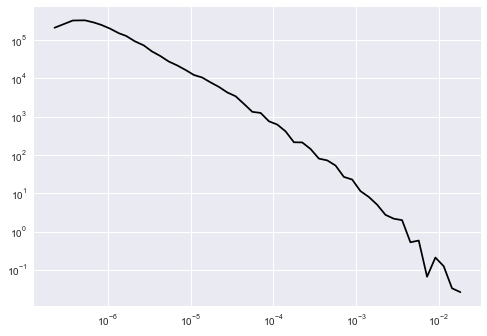

In [43]:
pl.plot_pdf(data, color = 'k')

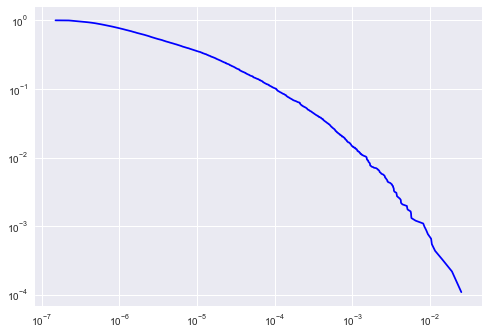

In [42]:
pl.plot_ccdf(data, color = 'b')

In [44]:
fit = pl.Fit(data)

Calculating best minimal value for power law fit
C:\Users\Ari\Anaconda3\lib\site-packages\powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


In [55]:
fit.distribution_compare('power_law', 'lognormal', normalized_ratio = True)

(-1.6704105710121435, 0.09483815958897665)

In [49]:
fit.supported_distributions

{'exponential': powerlaw.Exponential,
 'lognormal': powerlaw.Lognormal,
 'lognormal_positive': powerlaw.Lognormal_Positive,
 'power_law': powerlaw.Power_Law,
 'stretched_exponential': powerlaw.Stretched_Exponential,
 'truncated_power_law': powerlaw.Truncated_Power_Law}

In [59]:
stats.kstest(data, 'lognorm', stats.lognorm.fit(data))

KstestResult(statistic=0.05651791994737182, pvalue=9.8787899406531874e-26)

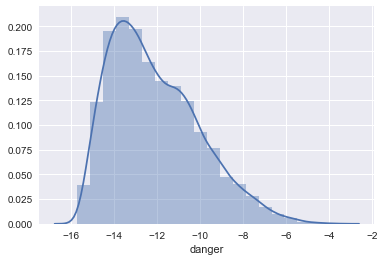

In [66]:
sns.distplot(np.log(crash_sev_loc_cond.groupby('STREET_NAME').sum().danger), bins = 20)

In [67]:
help(stats.mannwhitneyu)

Help on function mannwhitneyu in module scipy.stats.stats:

mannwhitneyu(x, y, use_continuity=True, alternative=None)
    Computes the Mann-Whitney rank test on samples x and y.
    
    Parameters
    ----------
    x, y : array_like
        Array of samples, should be one-dimensional.
    use_continuity : bool, optional
            Whether a continuity correction (1/2.) should be taken into
            account. Default is True.
    alternative : None (deprecated), 'less', 'two-sided', or 'greater'
            Whether to get the p-value for the one-sided hypothesis ('less'
            or 'greater') or for the two-sided hypothesis ('two-sided').
            Defaults to None, which results in a p-value half the size of
            the 'two-sided' p-value and a different U statistic. The
            default behavior is not the same as using 'less' or 'greater':
            it only exists for backward compatibility and is deprecated.
    
    Returns
    -------
    statistic : float
    

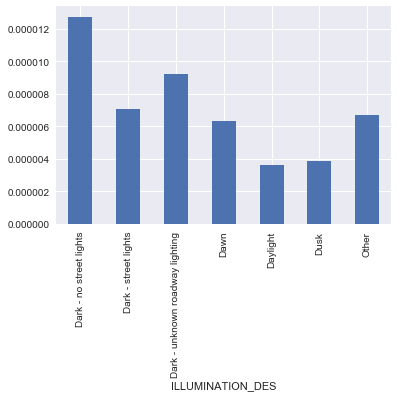

In [68]:
crash_sev_loc_cond.groupby('ILLUMINATION_DES').mean().danger.plot(kind = 'bar')

In [71]:
crash_sev_loc_cond.groupby('ILLUMINATION_DES').mean().danger

ILLUMINATION_DES
Dark - no street lights            0.000013
Dark - street lights               0.000007
Dark - unknown roadway lighting    0.000009
Dawn                               0.000006
Daylight                           0.000004
Dusk                               0.000004
Other                              0.000007
Name: danger, dtype: float64

In [77]:
darkness = crash_sev_loc_cond[crash_sev_loc_cond['ILLUMINATION_DES'] == 'Dark - no street lights'].danger
daylight = crash_sev_loc_cond[crash_sev_loc_cond['ILLUMINATION_DES'] == 'Daylight'].danger
darkness.shape, daylight.shape

((9461,), (88093,))

In [80]:
stats.mannwhitneyu(darkness, daylight, alternative = 'greater')

MannwhitneyuResult(statistic=547408338.0, pvalue=0.0)